In [2]:
import yaml
with open('prompts.yaml','r') as stream:
    prompt_templates=yaml.safe_load(stream)


In [3]:
#使用rag
from langchain.vectorstores import FAISS
from tools.Retriever_tool import RetrieverTool
from langchain.embeddings import HuggingFaceEmbeddings
vectordb=FAISS.load_local("./vectordb",embeddings=HuggingFaceEmbeddings(model_name="thenlper/gte-small"),allow_dangerous_deserialization=True)
retrievertool=RetrieverTool(vectordb=vectordb)

/var/folders/fk/d06243fj2t144tx3v08jk7_40000gn/T/ipykernel_41467/2312888540.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  vectordb=FAISS.load_local("./vectordb",embeddings=HuggingFaceEmbeddings(model_name="thenlper/gte-small"),allow_dangerous_deserialization=True)


In [4]:
#知识检索 agent
from smolagents import CodeAgent,OpenAIServerModel,tool,HfApiModel,DuckDuckGoSearchTool
from tools.final_answer import FinalAnswerTool
from tools.visit_webpage import VisitWebpageTool
from tools.vision_comprehension import VisionComprehension
from tools.file_io import file_writer
model=OpenAIServerModel(model_id='qwen-plus',api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",api_key="sk-615616fb539749dda57c80cc0928669d")
# model = HfApiModel(model_id="Qwen/Qwen2.5-Coder-32B-Instruct", provider="together")
qwen_agent=CodeAgent(model=model,
                     tools=[DuckDuckGoSearchTool(),file_writer(),retrievertool,VisitWebpageTool()],
                     additional_authorized_imports=['flask','os','matplotlib','pandas','numpy','seaborn','sklearn','torch','transformers','tensorflow','keras','cv2','PIL','matplotlib.pyplot','matplotlib.pyplot as plt','pandas as pd','numpy as np','seaborn as sns','sklearn as sk','torch as torch','transformers as transformers','tensorflow as tf','keras as keras','cv2 as cv2','PIL as PIL','matplotlib.pyplot as plt','matplotlib.pyplot as plt','pandas as pd','numpy as np','seaborn as sns','sklearn as sk','torch as torch','transformers as transformers','tensorflow as tf','keras as keras','cv2 as cv2','PIL as PIL'],
                     prompt_templates=prompt_templates,
                     name='qwen_agent',
                     description='information extraction agent,can do rag and web search')


In [5]:
#管理agent

from smolagents import CodeAgent,OpenAIServerModel,tool,HfApiModel,DuckDuckGoSearchTool
model=OpenAIServerModel(model_id='deepseek-v3',api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",api_key="sk-615616fb539749dda57c80cc0928669d")
# model = HfApiModel(model_id="Qwen/Qwen2.5-Coder-32B-Instruct", provider="together")
manage_agent=CodeAgent(model=model,
                       tools=[DuckDuckGoSearchTool(),file_writer(),FinalAnswerTool(),retrievertool],
                       additional_authorized_imports=['flask','os','matplotlib','pandas','numpy','seaborn','sklearn','torch','transformers','tensorflow','keras','cv2','PIL','matplotlib.pyplot','matplotlib.pyplot as plt','pandas as pd','numpy as np','seaborn as sns','sklearn as sk','torch as torch','transformers as transformers','tensorflow as tf','keras as keras','cv2 as cv2','PIL as PIL','matplotlib.pyplot as plt','matplotlib.pyplot as plt','pandas as pd','numpy as np','seaborn as sns','sklearn as sk','torch as torch','transformers as transformers','tensorflow as tf','keras as keras','cv2 as cv2','PIL as PIL'],
                       prompt_templates=prompt_templates,
                       max_steps=15,
                       planning_interval=5,
                       managed_agents=[qwen_agent]
                       )

In [19]:
manage_agent.visualize()

CodeAgent | deepseek-v3
├── ✅ Authorized imports: ['flask', 'os', 'matplotlib', 'pandas', 'numpy', 'seaborn', 'sklearn', 'torch', 
│   'transformers', 'tensorflow', 'keras', 'cv2', 'PIL', 'matplotlib.pyplot', 'matplotlib.pyplot as plt', 'pandas 
│   as pd', 'numpy as np', 'seaborn as sns', 'sklearn as sk', 'torch as torch', 'transformers as transformers', 
│   'tensorflow as tf', 'keras as keras', 'cv2 as cv2', 'PIL as PIL', 'matplotlib.pyplot as plt', 
│   'matplotlib.pyplot as plt', 'pandas as pd', 'numpy as np', 'seaborn as sns', 'sklearn as sk', 'torch as torch',
│   'transformers as transformers', 'tensorflow as tf', 'keras as keras', 'cv2 as cv2', 'PIL as PIL']
├── 🛠️ Tools:
│   ┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
│   ┃ Name         ┃ Description                                   ┃ Arguments                                    ┃
│   ┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   │ web_search   │ Performs a duckduckgo web search based on     │ query (`string`): The search query to        │
│   │              │ your query (think a Google search) then       │ perform.                                     │
│   │              │ returns the top search results.               │                                              │
│   │ file_writer  │ you can use this tool to write to a simple    │ filename (`string`): the name of the file    │
│   │              │ file                                          │ content (`string`): the content to write to  │
│   │              │                                               │ the file                                     │
│   │              │                                               │ mode (`boolean`): the mode to write to the   │
│   │              │                                               │ file, if true, the file will be appended, if │
│   │              │                                               │ false, the file will be overwritten          │
│   │ final_answer │ Provides a final answer to the given problem. │ answer (`any`): The final answer to the      │
│   │              │                                               │ problem                                      │
│   │ retriever    │ Using semantic similarity, retrieves some     │ query (`string`): The query to perform. This │
│   │              │ documents from the knowledge base that have   │ should be semantically close to your target  │
│   │              │ the closest embeddings to the input query.    │ documents. Use the affirmative form rather   │
│   │              │                                               │ than a question.                             │
│   └──────────────┴───────────────────────────────────────────────┴──────────────────────────────────────────────┘
└── 🤖 Managed agents:
    └── qwen_agent | CodeAgent | qwen-plus
        ├── ✅ Authorized imports: ['flask', 'os', 'matplotlib', 'pandas', 'numpy', 'seaborn', 'sklearn', 'torch', 
        │   'transformers', 'tensorflow', 'keras', 'cv2', 'PIL', 'matplotlib.pyplot', 'matplotlib.pyplot as plt', 
        │   'pandas as pd', 'numpy as np', 'seaborn as sns', 'sklearn as sk', 'torch as torch', 'transformers as 
        │   transformers', 'tensorflow as tf', 'keras as keras', 'cv2 as cv2', 'PIL as PIL', 'matplotlib.pyplot as 
        │   plt', 'matplotlib.pyplot as plt', 'pandas as pd', 'numpy as np', 'seaborn as sns', 'sklearn as sk', 
        │   'torch as torch', 'transformers as transformers', 'tensorflow as tf', 'keras as keras', 'cv2 as cv2', 
        │   'PIL as PIL']
        ├── 📝 Description: information extraction agent,can do rag and web search
        └── 🛠️ Tools:
            ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
            ┃ Name          ┃ Description                              ┃ Arguments                         

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 'data/anime-dataset-2023.csv' 请对这个数据集作探索性分析，生成的图表和分析结果均保存在 './temp' 目录下面        │
│                                                                                                                 │
╰─ OpenAIServerModel - deepseek-v3 ───────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
                ```
                1. **Data Loading and Cleaning**:  
   - Load the dataset 'data/anime-dataset-2023.csv' into a pandas DataFrame.  
   - Check for missing values, duplicates, and inconsistencies in the data.  
   - Clean the data by handling missing values, removing duplicates, and correcting inconsistencies.  
   - Save the cleaned dataset to './temp/cleaned_anime_data.csv'.  

2. **Exploratory Data Analysis (EDA) and Visualization**:  
   - Perform descriptive statistics to summarize the data (e.g., mean, median, mode, standard deviation).  
   - Visualize distributions of key variables (e.g., ratings, genres, episodes) using histograms, box plots, and 
bar charts.  
   - Analyze relationships between variables (e.g., correlation between rating and number of episodes) using 
scatter plots and heatmaps.  
   - Save all visualizations to './temp/eda_visualizations/'.  

3. **Statistical Analysis or Predictive Modeling**:  
   - Perform statistical tests (e.g., t-tests, ANOVA) to identify significant differences or relationships between 
variables.  
   - If applicable, build a predictive model (e.g., linear regression, classification) to predict a target variable
(e.g., rating, popularity).  
   - Evaluate the model's performance using appropriate metrics (e.g., R-squared, accuracy, F1-score).  
   - Save the statistical analysis results and model evaluation metrics to 
'./temp/statistical_analysis_results.txt'.  

4. **Interpretation of Results**:  
   - Summarize key findings from the EDA and statistical analysis.  
   - Provide insights and actionable recommendations based on the analysis.  
   - Save the interpretation and insights to './temp/interpretation_and_insights.txt'.  

<end_plan
                ```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import pandas as pd                                                                                              
  import matplotlib.pyplot as plt                                                                                  
  import os                                                                                                        
                                                                                                                   
  # Create the './temp' directory if it doesn't exist                                                              
  if not os.path.exists('./temp'):                                                                                 
      os.makedirs('./temp')                                                                                        
                                                                                                                   
  # Load the dataset                                                                                               
  data = pd.read_csv('data/anime-dataset-2023.csv')                                                                
                                                                                                                   
  # Initial exploration                                                                                            
  print(data.info())                                                                                               
  print(data.describe())                                                                                           
                                                                                                                   
  # Check for missing values                                                                                       
  print(data.isnull().sum())                                                                                       
                                                                                                                   
  # Check for duplicates                                                                                           
  print(data.duplicated().sum())                                                                                   
                                                                                                                   
  # Handle missing values (for simplicity, drop rows with missing values)                                          
  data_cleaned = data.dropna()                                                                                     
                                                                                                                   
  # Save the cleaned dataset                                                                                       
  data_cleaned.to_csv('./temp/cleaned_anime_data.csv', index=False)                                                
                                                                                                                   
  # Perform EDA                                                                                                    
  # Visualize the distribution of ratings                                                                          
  plt.figure(figsize=(10, 6))                                                                                      
  plt.hist(data_cleaned['rating'], bins=30, edgecolor='black')                                                     
  plt.title('Distribution of Anime Ratings')                                                                       
  plt.xlabel('Rating')                                                                                             
  plt.ylabel('Frequency')                                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

Execution logs:
None
           anime_id    Popularity      Favorites       Members
count  24905.000000  24905.000000   24905.000000  2.490500e+04
mean   29776.709014  12265.388356     432.595222  3.710496e+04
std    17976.076290   7187.428393    4353.181647  1.568252e+05
min        1.000000      0.000000       0.000000  0.000000e+00
25%    10507.000000   6040.000000       0.000000  2.090000e+02
50%    34628.000000  12265.000000       1.000000  1.056000e+03
75%    45240.000000  18491.000000      18.000000  9.326000e+03
max    55735.000000  24723.000000  217606.000000  3.744541e+06
anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64
0

Code execution failed at line 'plt.hist(data_cleaned['rating'], bins=30, edgecolor='black')' due to: KeyError: 
'rating'

[Step 0: Duration 126.91 seconds| Input tokens: 2,773 | Output tokens: 581]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import pandas as pd                                                                                              
  import matplotlib.pyplot as plt                                                                                  
  import os                                                                                                        
                                                                                                                   
  # Create the './temp' directory if it doesn't exist                                                              
  if not os.path.exists('./temp'):                                                                                 
      os.makedirs('./temp')                                                                                        
                                                                                                                   
  # Load the dataset                                                                                               
  data = pd.read_csv('data/anime-dataset-2023.csv')                                                                
                                                                                                                   
  # Initial exploration                                                                                            
  print(data.info())                                                                                               
  print(data.describe())                                                                                           
                                                                                                                   
  # Check for missing values                                                                                       
  print(data.isnull().sum())                                                                                       
                                                                                                                   
  # Check for duplicates                                                                                           
  print(data.duplicated().sum())                                                                                   
                                                                                                                   
  # Handle missing values (for simplicity, drop rows with missing values)                                          
  data_cleaned = data.dropna()                                                                                     
                                                                                                                   
  # Save the cleaned dataset                                                                                       
  data_cleaned.to_csv('./temp/cleaned_anime_data.csv', index=False)                                                
                                                                                                                   
  # Perform EDA                                                                                                    
  # Visualize the distribution of scores                                                                           
  plt.figure(figsize=(10, 6))                                                                                      
  plt.hist(data_cleaned['Score'], bins=30, edgecolor='black')                                                      
  plt.title('Distribution of Anime Scores')                                                                        
  plt.xlabel('Score')                                                                                              
  plt.ylabel('Frequency')                                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

Execution logs:
None
           anime_id    Popularity      Favorites       Members
count  24905.000000  24905.000000   24905.000000  2.490500e+04
mean   29776.709014  12265.388356     432.595222  3.710496e+04
std    17976.076290   7187.428393    4353.181647  1.568252e+05
min        1.000000      0.000000       0.000000  0.000000e+00
25%    10507.000000   6040.000000       0.000000  2.090000e+02
50%    34628.000000  12265.000000       1.000000  1.056000e+03
75%    45240.000000  18491.000000      18.000000  9.326000e+03
max    55735.000000  24723.000000  217606.000000  3.744541e+06
anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64
0

Code execution failed at line 'plt.savefig('./temp/eda_visualizations/scores_distribution.png')' due to: 
FileNotFoundError: [Errno 2] No such file or directory: './temp/eda_visualizations/scores_distribution.png'

[Step 1: Duration 47.51 seconds| Input tokens: 7,184 | Output tokens: 1,153]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import pandas as pd                                                                                              
  import matplotlib.pyplot as plt                                                                                  
  import os                                                                                                        
                                                                                                                   
  # Create the './temp' directory and subdirectories if they don't exist                                           
  if not os.path.exists('./temp'):                                                                                 
      os.makedirs('./temp')                                                                                        
  if not os.path.exists('./temp/eda_visualizations'):                                                              
      os.makedirs('./temp/eda_visualizations')                                                                     
                                                                                                                   
  # Load the dataset                                                                                               
  data = pd.read_csv('data/anime-dataset-2023.csv')                                                                
                                                                                                                   
  # Initial exploration                                                                                            
  print(data.info())                                                                                               
  print(data.describe())                                                                                           
                                                                                                                   
  # Check for missing values                                                                                       
  print(data.isnull().sum())                                                                                       
                                                                                                                   
  # Check for duplicates                                                                                           
  print(data.duplicated().sum())                                                                                   
                                                                                                                   
  # Handle missing values (for simplicity, drop rows with missing values)                                          
  data_cleaned = data.dropna()                                                                                     
                                                                                                                   
  # Save the cleaned dataset                                                                                       
  data_cleaned.to_csv('./temp/cleaned_anime_data.csv', index=False)                                                
                                                                                                                   
  # Perform EDA                                                                                                    
  # Visualize the distribution of scores                                                                           
  plt.figure(figsize=(10, 6))                                                                                      
  plt.hist(data_cleaned['Score'], bins=30, edgecolor='black')                                                      
  plt.title('Distribution of Anime Scores')              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

Execution logs:
None
           anime_id    Popularity      Favorites       Members
count  24905.000000  24905.000000   24905.000000  2.490500e+04
mean   29776.709014  12265.388356     432.595222  3.710496e+04
std    17976.076290   7187.428393    4353.181647  1.568252e+05
min        1.000000      0.000000       0.000000  0.000000e+00
25%    10507.000000   6040.000000       0.000000  2.090000e+02
50%    34628.000000  12265.000000       1.000000  1.056000e+03
75%    45240.000000  18491.000000      18.000000  9.326000e+03
max    55735.000000  24723.000000  217606.000000  3.744541e+06
anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64
0

Out: ./temp/eda_results.txt

[Step 2: Duration 37.32 seconds| Input tokens: 13,243 | Output tokens: 1,743]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Read the EDA results from the saved file                                                                       
  with open('./temp/eda_results.txt', 'r') as file:                                                                
      eda_results = file.read()                                                                                    
                                                                                                                   
  # Provide the final answer                                                                                       
  final_answer({                                                                                                   
      "message": "Exploratory data analysis completed successfully.",                                              
      "cleaned_dataset": "./temp/cleaned_anime_data.csv",                                                          
      "eda_results": eda_results                                                                                   
  })                                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'with open('./temp/eda_results.txt', 'r') as file:
    eda_results = file.read()' due to: InterpreterError: It is not permitted to evaluate other functions than the 
provided tools or functions defined/imported in previous code (tried to execute open).

[Step 3: Duration 9.04 seconds| Input tokens: 20,922 | Output tokens: 1,871]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Provide the final answer                                                                                       
  final_answer({                                                                                                   
      "message": "Exploratory data analysis completed successfully.",                                              
      "cleaned_dataset": "./temp/cleaned_anime_data.csv",                                                          
      "eda_results": {                                                                                             
          "scores_distribution": "./temp/eda_visualizations/scores_distribution.png",                              
          "episodes_distribution": "./temp/eda_visualizations/episodes_distribution.png",                          
          "score_vs_episodes": "./temp/eda_visualizations/score_vs_episodes.png"                                   
      }                                                                                                            
  })                                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {'message': 'Exploratory data analysis completed successfully.', 'cleaned_dataset': 
'./temp/cleaned_anime_data.csv', 'eda_results': {'scores_distribution': 
'./temp/eda_visualizations/scores_distribution.png', 'episodes_distribution': 
'./temp/eda_visualizations/episodes_distribution.png', 'score_vs_episodes': 
'./temp/eda_visualizations/score_vs_episodes.png'}}

[Step 4: Duration 17.21 seconds| Input tokens: 28,970 | Output tokens: 2,180]

{'message': 'Exploratory data analysis completed successfully.',
 'cleaned_dataset': './temp/cleaned_anime_data.csv',
 'eda_results': {'scores_distribution': './temp/eda_visualizations/scores_distribution.png',
  'episodes_distribution': './temp/eda_visualizations/episodes_distribution.png',
  'score_vs_episodes': './temp/eda_visualizations/score_vs_episodes.png'}}

<Figure size 1000x600 with 0 Axes>

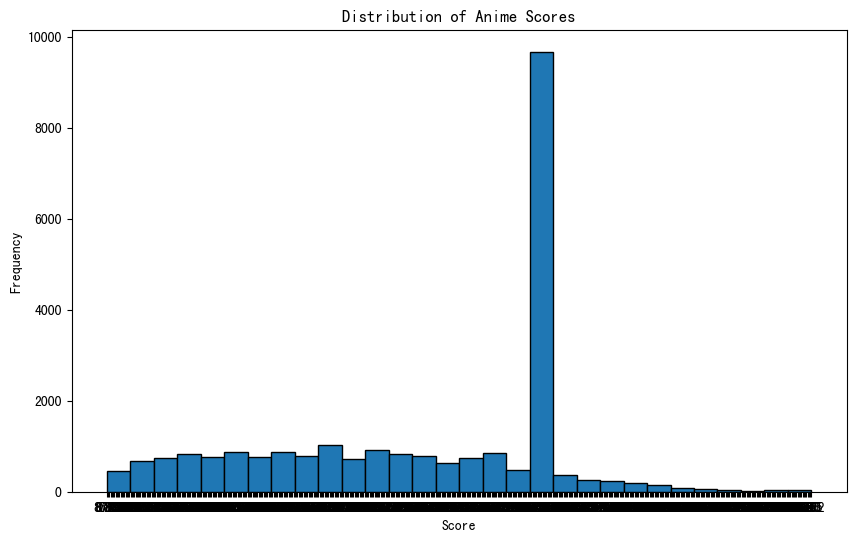

In [20]:
manage_agent.run("'data/anime-dataset-2023.csv' 请对这个数据集作探索性分析，生成的图表和分析结果均保存在 './temp' 目录下面")

In [6]:
model=OpenAIServerModel(model_id='deepseek-v3',api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",api_key="sk-615616fb539749dda57c80cc0928669d")
anaylse_agent=CodeAgent(
    model=model,
    tools=[
        RetrieverTool(vectordb=vectordb),
        VisitWebpageTool(),
        DuckDuckGoSearchTool(),
        VisionComprehension(),
        file_writer(),
        FinalAnswerTool(),
    ],
    max_steps=15,
)

In [7]:
anaylse_agent.run("请利用'./temp' 目录下面的文件（包括图片和txt），帮我写一份数据分析报告")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 请利用'./temp' 目录下面的文件（包括图片和txt），帮我写一份数据分析报告                                          │
│                                                                                                                 │
╰─ OpenAIServerModel - deepseek-v3 ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import os                                                                                                        
                                                                                                                   
  # 列出./temp目录下的所有文件                                                                                     
  files = os.listdir('./temp')                                                                                     
  print(files)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Warning to user: Code execution failed due to an unauthorized import - Consider passing said import under 
`additional_authorized_imports` when initializing your CodeAgent.

Code execution failed at line 'import os' due to: InterpreterError: Import of os is not allowed. Authorized imports
are: ['stat', 'unicodedata', 'statistics', 'time', 'collections', 'queue', 'itertools', 'math', 're', 'datetime', 
'random']

[Step 0: Duration 5.08 seconds| Input tokens: 2,438 | Output tokens: 77]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # 使用retriever工具获取./temp目录下的文件信息                                                                    
  files_info = retriever(query="files in ./temp directory")                                                        
  print(files_info)                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:
===== Document 0 =====
1.1.2 目标===== Document 1 =====
temp = []  
if count <=23:  
temp.append(i['od21'])     # 添加时间 
temp.append(i['od22'])     # 添加当前时刻温度  
temp.append(i['od24'])     # 添加当前时刻风力方向  
temp.append(i['od25'])     # 添加当前时刻风级 
temp.append(i['od26'])     # 添加当前时刻降水量  
temp.append(i['od27'])     # 添加当前时刻相对湿度===== Document 2 =====
如Python、Perl、R或Java）或UNIX文本处理工具（如sed或awk===== Document 3 =====
帮助用户更好地规划和选择旅行。首先，数据采集的目标是获取尽可能多的酒店信息。通过===== Document 4 =====
temp.append(i['od28'])     # 添加当前时刻控制质量  
#print(temp)  
final_day.append(temp)  
count = count +1
下面爬取7天的数据===== Document 5 =====
tem_low = inf[1].find('i').string   # 找到最低气温===== Document 6 =====
if inf[1].find('span') is None:   # 天气预报可能没有最高气温  
        tem_high = None  
    else:  
        tem_high = inf[1].find('span').string  # 找到最高气温  
    temp.append(tem_low[:-1])  
    if tem_high[-1] == '℃':  
     temp.append(tem_high[:-1])  
    else:  
     temp.append(tem_high)  
    wind = inf[2].find_all('span')  # 找到风向  
    for j in wind:

Out: None

[Step 1: Duration 6.70 seconds| Input tokens: 5,126 | Output tokens: 165]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[Step 2: Duration 23.83 seconds| Input tokens: 7,814 | Output tokens: 253]

KeyboardInterrupt: 